# House pricing prediction excercise
Aleksander Molak

* ## Import libs

In [74]:
import numpy as np

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import datetime
import winsound
import time

from scipy.special import boxcox

import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

* ## Define helper functions

In [3]:
def get_cv_info(model, X, y, cv=5):
    cv_score = cross_val_score(model, X, y, cv=cv)
    print('CV scores: {}\nMean score: {}'.format(cv_score, np.mean(cv_score)))

In [58]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    # This function has been created by sklearn developers and can be found 
    # @ sklearn documentation
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [5]:
def end_signal():            # Hey, computer, let me know when you're done!
    winsound.Beep(440, 100)
    time.sleep(.05)
    winsound.Beep(660, 100)

* ## Import and explore data

* Import data and filter out the columns that are not going to be used

In [6]:
data = pd.read_csv(r'..\house.csv',
                  usecols=['id', 'date', 'price', 'bedrooms', 'bathrooms',
                           'sqft_living', 'sqft_lot', 'floors', 'waterfront',
                           'view', 'condition', 'grade', 'sqft_above', 
                           'sqft_basement', 'yr_built'])

* Quick look at the data

In [7]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987


* Convert date column to a datetime object for further time-related EDA

In [8]:
data.date = pd.to_datetime(data.date)

* Check data types + check for missing values

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 15 columns):
id               21613 non-null int64
date             21613 non-null datetime64[ns]
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(11)
memory usage: 2.5 MB


There are no missing values in the dataset

In [10]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000


It seems that there are floats in ``bathroom`` column.

In [11]:
data[data.bathrooms%1 != 0].sample(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
8629,2926049086,2014-10-28,575000.0,7,1.50,2670,11250,1.5,0,0,4,8,2320,350,1948
9871,3856905185,2014-06-24,483000.0,2,1.75,1240,3000,1.5,0,0,3,7,1240,0,1906
21462,5694000706,2014-08-13,535000.0,3,2.75,1320,1125,3.0,0,0,3,8,1320,0,2008


There are, but it's not an error:

* http://www.city-data.com/forum/real-estate/1664093-fractional-bathrooms.html
* https://support.dobovo.com/hc/en-us/articles/225557108-What-does-a-fractional-number-of-bathrooms-in-an-apartment-mean-

* Examine correlations in the data

In [12]:
# Quick look at correlations in the data
data_corr = data.corr(method='pearson')

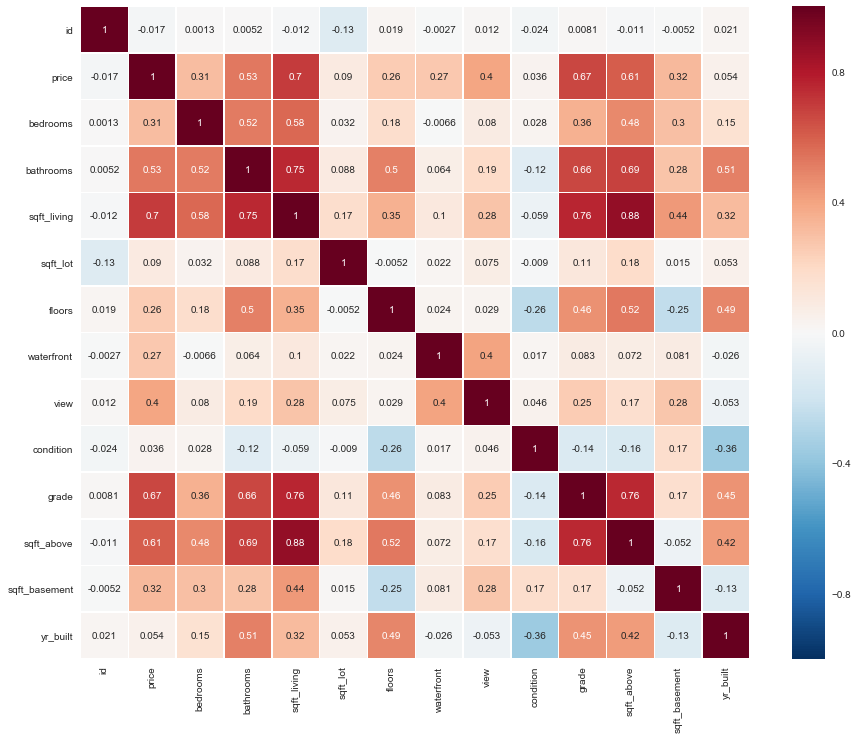

In [13]:
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(data_corr, linewidths=.5, ax=ax, cmap='RdBu_r', vmin=-1, vmax=1, annot=True)

* Examine data distributions and correlations

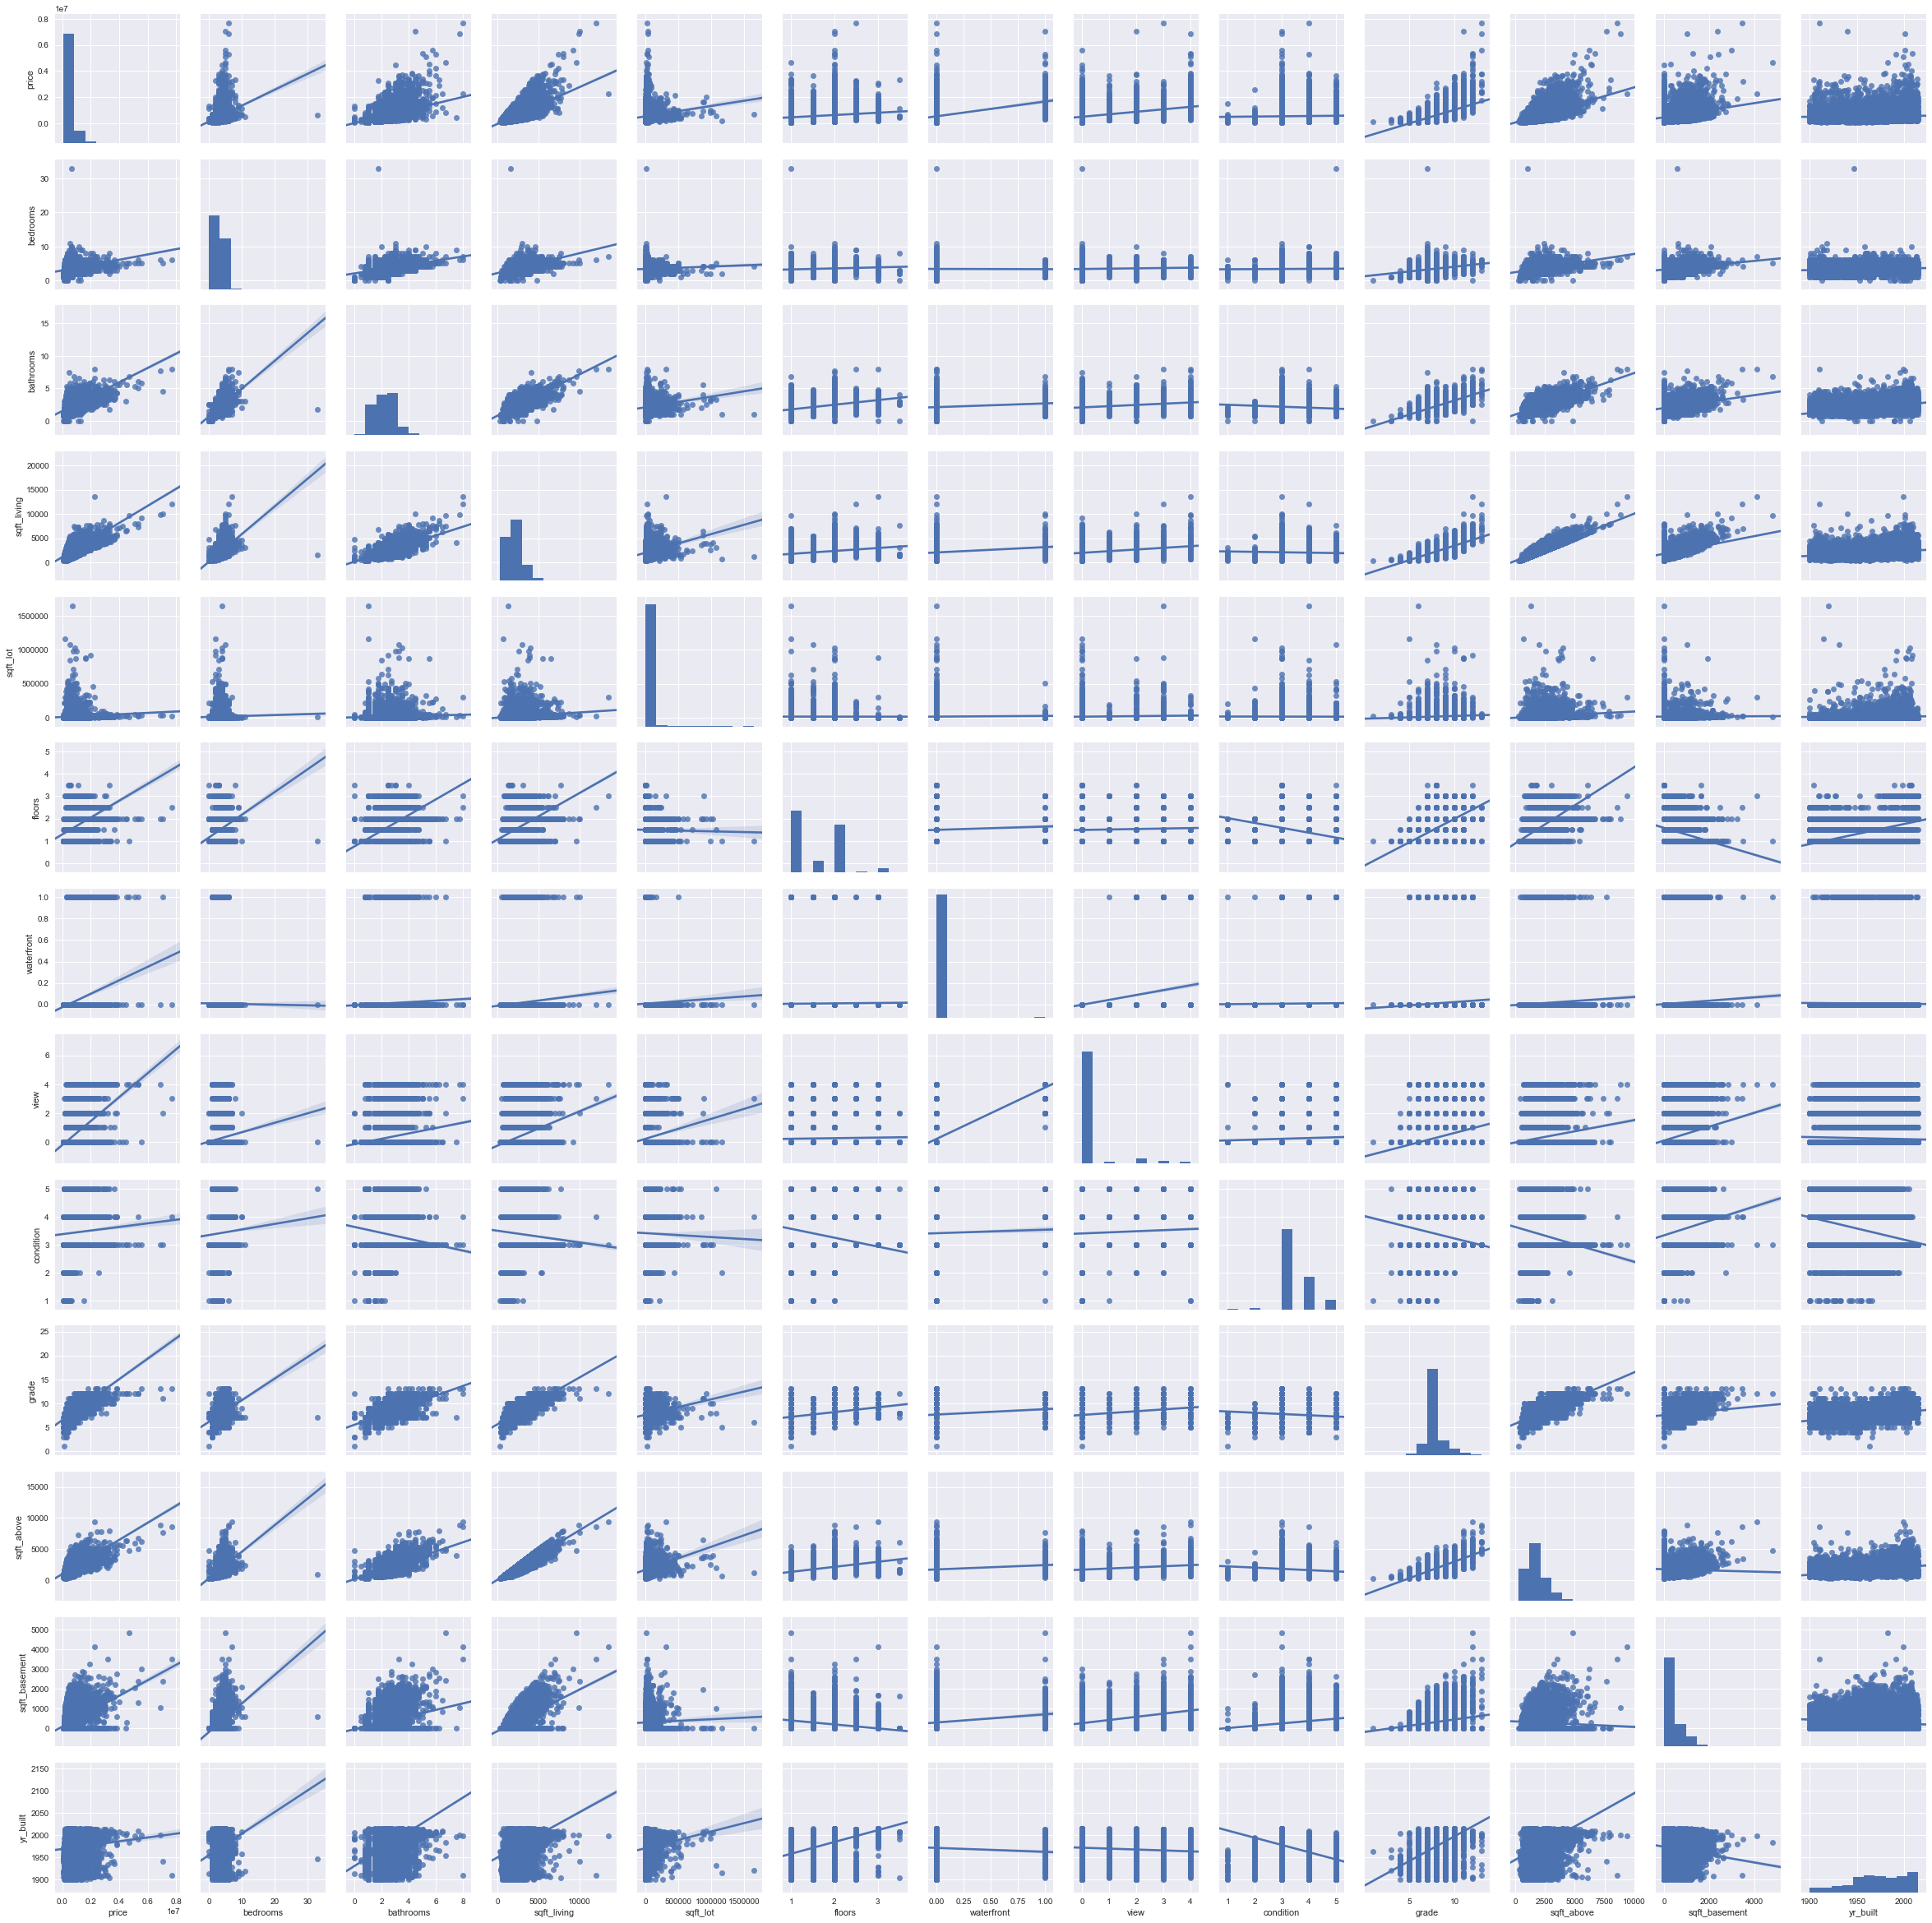

In [90]:
sns.pairplot(data.iloc[:,2:], kind='reg')

* The observation with 30+ bedrooms is a clear outlier. Let's drop it:

In [30]:
data = data[data.bedrooms < 30]

* There's also an outlying observation with ``sqft_lot > 1500000``. 

In [31]:
(data.sqft_lot > 1500000).sum()

1

In [32]:
data = data[data.sqft_lot < 1500000]

* Let's generate a new pairplot:

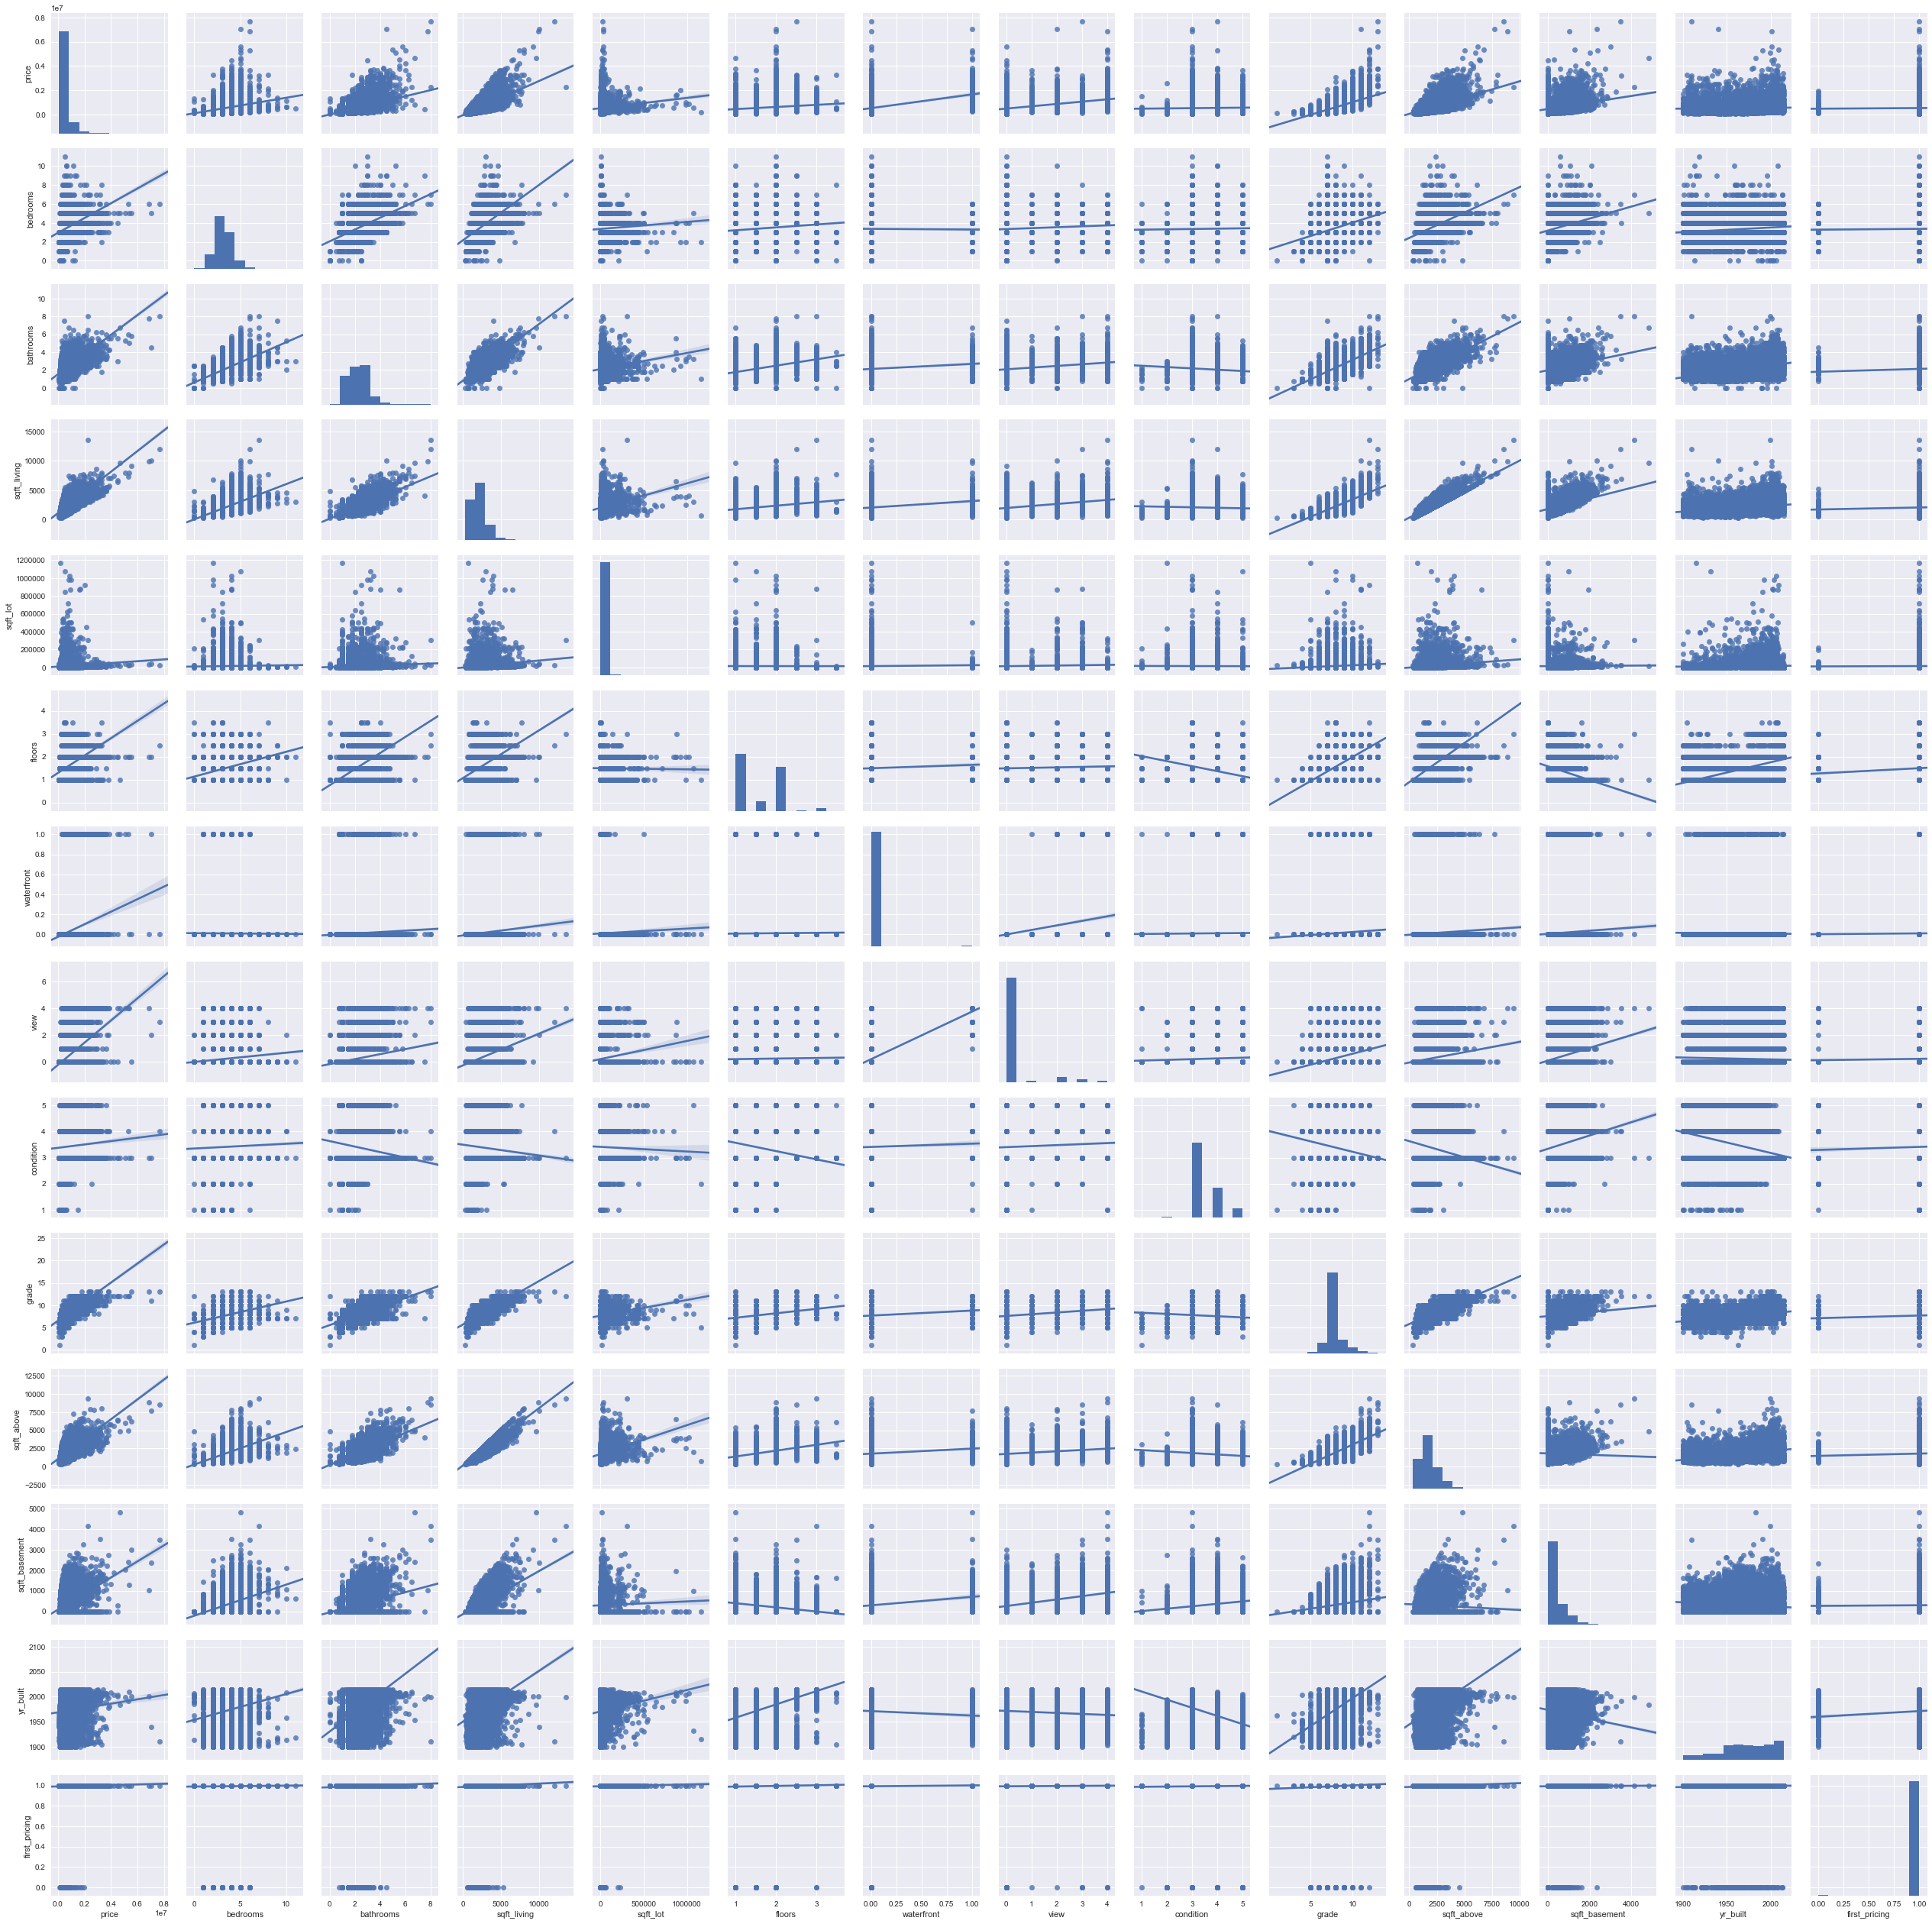

In [118]:
sns.pairplot(data.iloc[:,2:], kind='reg')

* ## Feature engineering

* Let's see if ``date`` is a predictor of ``price``. First, let's plot price vs time.

In [14]:
price_weekly = data.set_index('date').price.resample(rule='W').mean()

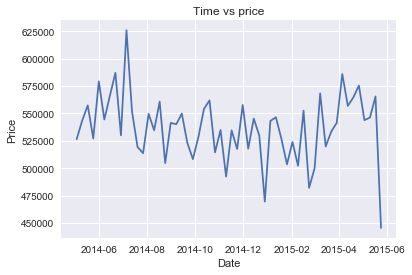

In [15]:
plt.figure(figsize=(6,4))
plt.plot(price_weekly[:'2015-05-30'])    # Removing the last observation as it's the only
plt.title('Time vs price')               # observation in the last week and it introduces noise
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

It seems like there's no obvious pattern in the data. Let's use Augmented Dickey-Fuller test to examine if the data follows a random walk.

In [16]:
# Peform ADF
results = adfuller(price_weekly.values)

# Report ADF

if results[1] < .05:
    decision = 'reject (alpha=.05)'
else:
    decision = 'retain (alpha=.05)'
    
print('ADF: {:02f}\np-value: {:04f}\nNull: {}'\
      .format(results[0], results[1], decision))

ADF: -5.338804
p-value: 0.000005
Null: reject (alpha=.05)


According to ADF test results ```price``` (at least when averaged week-wise) does not follow a random walk. Thus time can possibly be a useful predictor of ``price``. Let's convert ```date``` column to a format that can be used by an ML algorithm.

* Let's find the date of the first observation in our dataset

In [17]:
min(data.date)

Timestamp('2014-05-02 00:00:00')

* Let's define a timepoint from which we will count time - our *time zero*

In [18]:
timepoint_0 = datetime.datetime(2014,5,1,0,0,0)

* Let's convert ``date`` to minutes from ``timepoint_0`` 

In [19]:
data.date = (data.date - timepoint_0) / np.timedelta64(1,'m')

* Let's check if there are any duplicates in the data

In [21]:
len(data) - len(data.id.unique())

177

It seems that there are some duplicates in the data. 

Are some houses priced more than once (possibly at different timepoints)?
* Let's check it out!

In [22]:
dup_fltr = data.duplicated('id', keep=False)

In [23]:
data[dup_fltr].head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
93,6021501535,122400.0,430000.0,3,1.50,1580,5000,1.0,0,0,3,8,1290,290,1939
94,6021501535,339840.0,700000.0,3,1.50,1580,5000,1.0,0,0,3,8,1290,290,1939
313,4139480200,69120.0,1384000.0,4,3.25,4290,12103,1.0,0,3,3,11,2690,1600,1997
314,4139480200,319680.0,1400000.0,4,3.25,4290,12103,1.0,0,3,3,11,2690,1600,1997
324,7520000520,182880.0,232000.0,2,1.00,1240,12092,1.0,0,0,3,6,960,280,1922
325,7520000520,452160.0,240500.0,2,1.00,1240,12092,1.0,0,0,3,6,960,280,1922
345,3969300030,119520.0,165000.0,4,1.00,1000,7134,1.0,0,0,3,6,1000,0,1943
346,3969300030,348480.0,239900.0,4,1.00,1000,7134,1.0,0,0,3,6,1000,0,1943
371,2231500030,220320.0,315000.0,4,2.25,2180,10754,1.0,0,0,5,7,1100,1080,1954
372,2231500030,470880.0,530000.0,4,2.25,2180,10754,1.0,0,0,5,7,1100,1080,1954


It seems that some houses were priced at least twice. The trend seems to be that if the house was priced twice, the second pricing was higher than the first one. It can be a valuable insight. Let's check if any of the houses was priced more than twice. Then let's examine if the trend towards higher second princing is stable in the data. 

In [24]:
more_than_twice = 0

for i in data[dup_fltr].id.value_counts():
    if i > 2:
        more_than_twice += 1

more_than_twice

1

There's one house that was priced more than twice. Let's create a new binary variable ``first_pricing`` that will equal `1` in case of first pricing and `0` otherwise. 

In [25]:
first_indx = data.sort_values('date').drop_duplicates(subset='id', keep='first').index

In [26]:
data['first_pricing'] = np.zeros(data.shape[0])

In [27]:
data.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,first_pricing
0,7129300520,237600.0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0.0
1,6414100192,319680.0,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,0.0
2,5631500400,432000.0,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0.0


In [28]:
for i in first_indx:
    data.iloc[i, 15] = 1

* Check if everything went ok

In [29]:
(data.first_pricing == 0).sum()

177

* ## Preliminary modeling

* Let's prepare data for modeling stage

In [80]:
X = data.drop(['price', 'id'], axis=1)
y = data.price

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

* Try a few different methods (raw)

In [35]:
lin_reg = LinearRegression(normalize=True)

In [36]:
get_cv_info(lin_reg, X_train, y_train, cv=10)

CV scores: [0.65297725 0.66342659 0.65310373 0.66613708 0.64516033 0.62910772
 0.65821927 0.6519279  0.65904947 0.60649246]
Mean score: 0.6485601793347746


In [37]:
lasso = Lasso(normalize=True, max_iter=10000)

In [38]:
get_cv_info(lasso, X_train, y_train, cv=10)

CV scores: [0.65286996 0.66331538 0.65314613 0.66612649 0.64529591 0.62912343
 0.6595178  0.65200664 0.65891545 0.60661989]
Mean score: 0.6486937082864498


In [39]:
ridge = Ridge(normalize=True)

In [40]:
get_cv_info(ridge, X_train, y_train, cv=10)

CV scores: [0.56466409 0.55691958 0.58682913 0.59097874 0.57940907 0.55008665
 0.6018169  0.57476203 0.5613735  0.55607274]
Mean score: 0.572291242687666


In [41]:
gbr = GradientBoostingRegressor()

In [42]:
get_cv_info(gbr, X_train, y_train, cv=10)

CV scores: [0.73130699 0.76988771 0.71088838 0.72420811 0.73032186 0.72558297
 0.65943183 0.72324997 0.73124103 0.66283157]
Mean score: 0.716895042717441


* Let's try adding polynomial features and interactions. I'll not try ridge regression here because it gave really poor results out of the box. If lasso will perform decently on polynomial features I will maybe decide to try elastic net at later stage. Elastic net combines L1 regularization (that is found in lasso) and L2 regularization (found in ridge regression) and L1/L2 ratio can be tuned using cv grid search.

In [43]:
poly = PolynomialFeatures(include_bias=False)

In [44]:
X_poly = poly.fit_transform(X)

In [45]:
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) \
                                  for pair in tuple if pair[1]!=0]) \
                        for tuple in [zip(X.columns,p) for p in poly.powers_]]

X_poly = pd.DataFrame(X_poly, columns = target_feature_names)

In [46]:
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, test_size=.25)

In [47]:
get_cv_info(lin_reg, X_poly_train, y_poly_train, cv=10)

CV scores: [0.63820844 0.72750707 0.72187275 0.66973349 0.71831105 0.7585519
 0.71367558 0.71258336 0.72257675 0.68629077]
Mean score: 0.7069311158997309


Adding these features worked really good for linear regression! 

In [48]:
get_cv_info(gbr, X_poly_train, y_poly_train, cv=10)

CV scores: [0.68380982 0.75600648 0.74087167 0.68861143 0.74251477 0.75842668
 0.71227386 0.71965932 0.72403005 0.67511052]
Mean score: 0.7201314601869159


In [54]:
lasso = Lasso(normalize=True, tol=.1)
get_cv_info(lasso, X_poly_train, y_poly_train, cv=10)

CV scores: [0.61995109 0.72224951 0.7240005  0.66338527 0.70844206 0.75682615
 0.7065288  0.7060679  0.70578869 0.69173206]
Mean score: 0.7004972035644385


``GradientBoostingRegressor()`` remains the best after adding polynomial and interaction features. I will further tune this regressor only.

* ## Model tuning

* ### Tuning tree-specific parameters

First I'm going to tune tree-specific parameters in gbr. To keep this process fast and efficient I will use rather high value of learning rate and a low number of estimators. I will begin with finding an optimal (small) number of estimators for sklearn's default learning rate (0.1). 

This approach is based on a proposal by Arshain Jain and worked for me before:
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [156]:
n_estim = range(20,81,10)

In [157]:
gbr_params_1 = {'n_estimators': n_estim, 'subsample': [.8], 'min_samples_split': [500],\
               'max_features': ['sqrt'], 'min_samples_leaf': [50], 'max_depth': range(1,11,1)}

In [158]:
gbr_cv = GridSearchCV(gbr, gbr_params_1, cv=5)

In [159]:
gbr_cv.fit(X_poly_train, y_poly_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(20, 81, 10), 'subsample': [0.8], 'min_samples_split': [500], 'max_features': ['sqrt'], 'min_samples_leaf': [50], 'max_depth': range(1, 11)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [161]:
# Get the best parameters
gbr_cv.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 50,
 'min_samples_split': 500,
 'n_estimators': 80,
 'subsample': 0.8}

In [162]:
# Check the best CV score
gbr_cv.best_score_

0.7173552071038635

In [163]:
# Tune min_samples_split
gbr_params_2 = {'max_depth': [10], 'max_features': ['sqrt'],
 'min_samples_leaf': [50],
 'min_samples_split': [500],
 'n_estimators': [80],
 'subsample': [0.8]}
gbr_params_2['min_samples_split'] = range(100,1001,100)

In [164]:
gbr_cv = GridSearchCV(gbr, gbr_params_2, cv=5)
gbr_cv.fit(X_poly_train, y_poly_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [10], 'max_features': ['sqrt'], 'min_samples_leaf': [50], 'min_samples_split': range(100, 1001, 100), 'n_estimators': [80], 'subsample': [0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [165]:
gbr_cv.best_params_, gbr_cv.best_score_

({'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 50,
  'min_samples_split': 100,
  'n_estimators': 80,
  'subsample': 0.8},
 0.7232161929089379)

The smallest ``min_samples_split`` value was chosen as the best. Let's try a lower range.

In [169]:
gbr_params_3 = {'max_depth': [10], 
 'max_features': ['sqrt'],
 'min_samples_leaf': [50],
 'min_samples_split': [100],
 'n_estimators': [80],
 'subsample': [0.8]}
gbr_params_3['min_samples_split'] = range(10,121,10)

In [170]:
gbr_cv = GridSearchCV(gbr, gbr_params_3, cv=5)
gbr_cv.fit(X_poly_train, y_poly_train)
end_signal()

In [171]:
gbr_cv.best_params_, gbr_cv.best_score_

({'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 50,
  'min_samples_split': 50,
  'n_estimators': 80,
  'subsample': 0.8},
 0.7219471672252146)

In [174]:
# Tune max_features
gbr_params_4 = {'max_depth': [10],
 'min_samples_leaf': [50],
 'min_samples_split': [50],
 'n_estimators': [80],
 'subsample': [0.8],
 'max_features': range(5,12,1)}

In [175]:
gbr_cv = GridSearchCV(gbr, gbr_params_4, cv=5)
gbr_cv.fit(X_poly_train, y_poly_train)
end_signal()
gbr_cv.best_params_, gbr_cv.best_score_

({'max_depth': 10,
  'max_features': 9,
  'min_samples_leaf': 50,
  'min_samples_split': 50,
  'n_estimators': 80,
  'subsample': 0.8},
 0.7226722644395626)

* ### Tuning boosting parameters

Now I'm going to find a optimal value of subsample

In [177]:
gbr_params_5 = {'max_depth': [10],
 'min_samples_leaf': [50],
 'min_samples_split': [50],
 'n_estimators': [80],
 'subsample': [.5, .6, .7, .75, .8, .85, .9, 1],
 'max_features': [9]}

In [178]:
gbr_cv = GridSearchCV(gbr, gbr_params_5, cv=5)
gbr_cv.fit(X_poly_train, y_poly_train)
end_signal()
gbr_cv.best_params_, gbr_cv.best_score_

({'max_depth': 10,
  'max_features': 9,
  'min_samples_leaf': 50,
  'min_samples_split': 50,
  'n_estimators': 80,
  'subsample': 0.9},
 0.7234113948290184)

In the next steps I'll tune learning rate and number of estimators. I'm going to try Greg Ridgeway's (2005/2012) approach presented in his paper "Generalized Boosted Models:
A guide to the gbm package" (https://pdfs.semanticscholar.org/a3f6/d964ac323b87d2de3434b23444cb774a216e.pdf).

Ridgeway shows that very low learning rate with a relatively high (3000-10000) number of estimators can result in better generalizability. I will gradually decrease ``learning_rate`` and increase ``n_estimators`` respectively.

In [40]:
gbr_params_6 = {'max_depth': [10],
 'min_samples_leaf': [50],
 'min_samples_split': [50],
 'n_estimators': [1000],
 'subsample': [.9],
 'max_features': [9],
 'learning_rate': [.03, .01]}

In [41]:
gbr_cv = GridSearchCV(gbr, gbr_params_6, cv=5)
gbr_cv.fit(X_poly_train, y_poly_train)
end_signal()
gbr_cv.best_params_, gbr_cv.best_score_

({'learning_rate': 0.01,
  'max_depth': 10,
  'max_features': 9,
  'min_samples_leaf': 50,
  'min_samples_split': 50,
  'n_estimators': 1000,
  'subsample': 0.9},
 0.7252347626039012)

In [43]:
gbr_params_7 = {'max_depth': [10],
 'min_samples_leaf': [50],
 'min_samples_split': [50],
 'n_estimators': [3000],
 'subsample': [.9],
 'max_features': [9],
 'learning_rate': [.006, .001]}

In [44]:
gbr_cv = GridSearchCV(gbr, gbr_params_7, cv=5)
gbr_cv.fit(X_poly_train, y_poly_train)
end_signal()
gbr_cv.best_params_, gbr_cv.best_score_

({'learning_rate': 0.006,
  'max_depth': 10,
  'max_features': 9,
  'min_samples_leaf': 50,
  'min_samples_split': 50,
  'n_estimators': 3000,
  'subsample': 0.9},
 0.7256043571084678)

In [45]:
gbr_params_8 = {'max_depth': [10],
 'min_samples_leaf': [50],
 'min_samples_split': [50],
 'n_estimators': [5000],
 'subsample': [.9],
 'max_features': [9],
 'learning_rate': [.006, .001]}

In [46]:
gbr_cv = GridSearchCV(gbr, gbr_params_8, cv=5)
gbr_cv.fit(X_poly_train, y_poly_train)
end_signal()
gbr_cv.best_params_, gbr_cv.best_score_

({'learning_rate': 0.006,
  'max_depth': 10,
  'max_features': 9,
  'min_samples_leaf': 50,
  'min_samples_split': 50,
  'n_estimators': 5000,
  'subsample': 0.9},
 0.7240051271954449)

$R^2$ dropped here. One of two things could happen: we're overfitting or ``n_estimators`` is too small. I'll try one more setting in accordance with Ridgeway's (2012) approach and then examine ``gbr``'s learning curve.

In [47]:
gbr_params_9 = {'max_depth': [10],
 'min_samples_leaf': [50],
 'min_samples_split': [50],
 'n_estimators': [10000],
 'subsample': [.9],
 'max_features': [9],
 'learning_rate': [.001]}

In [48]:
gbr_cv = GridSearchCV(gbr, gbr_params_9, cv=5)
gbr_cv.fit(X_poly_train, y_poly_train)
end_signal()
gbr_cv.best_params_, gbr_cv.best_score_

({'learning_rate': 0.001,
  'max_depth': 10,
  'max_features': 9,
  'min_samples_leaf': 50,
  'min_samples_split': 50,
  'n_estimators': 10000,
  'subsample': 0.9},
 0.7256490376706719)

In [56]:
gbr_3 = GradientBoostingRegressor(**{'learning_rate': 0.001,
  'max_depth': 10,
  'max_features': 9,
  'min_samples_leaf': 50,
  'min_samples_split': 50,
  'n_estimators': 10000,
  'subsample': 0.9})

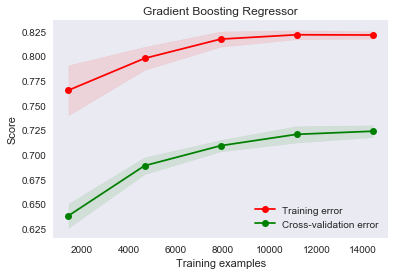

In [57]:
plot_learning_curve(gbr_3, 'Gradient Boosting Regressor', X_poly, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
end_signal()

**! Please note that there's an error** in the **legend**: *instead of 'training error' should be 'training score' and instead of 'cross-val. error' should be  'cross-val. score''*

It seems that the model is overfitting. I'll try to tune re-tune trees depth (``max_depth``). I'll use ``range(1, 5)``.  James, Witten, Hastie and Tibshirani in "An Introduction to Statistical Learning" (2013) say that stumps (trees of depth 1) can increase gbm's robustness against overfitting.

In [64]:
gbr_params_10 = {'max_depth': [1,3,7,10],
 'min_samples_leaf': [50],
 'min_samples_split': [50],
 'n_estimators': [10000],
 'subsample': [.9],
 'max_features': [9],
 'learning_rate': [.001]}

In [65]:
gbr_cv = GridSearchCV(gbr, gbr_params_10, cv=5)
gbr_cv.fit(X_poly_train, y_poly_train)
end_signal()
gbr_cv.best_params_, gbr_cv.best_score_

({'learning_rate': 0.001,
  'max_depth': 10,
  'max_features': 9,
  'min_samples_leaf': 50,
  'min_samples_split': 50,
  'n_estimators': 10000,
  'subsample': 0.9},
 0.7201487235358695)

It seems like ``max_depth`` of 10 works good for these parameters. In the last step I'll try to re-tune ``subsample``.

** Note ** that the $R^2$ value in the cell above (``Out[65]``) is lower than $R^2$ value in the cell ``Out[48]`` due to the fact that I needed to restart system between tunings and therefore performed ``train_test_split`` again after the restart. I didn't want re-run all the cells because of a long time needed for computations.

In [69]:
gbr_params_11 = {'max_depth': [10],
 'min_samples_leaf': [50],
 'min_samples_split': [50],
 'n_estimators': [10000],
 'subsample': [.5, .8],
 'max_features': [9],
 'learning_rate': [.001]}

In [70]:
gbr_cv = GridSearchCV(gbr, gbr_params_11, cv=5)
gbr_cv.fit(X_poly_train, y_poly_train)
end_signal()
gbr_cv.best_params_, gbr_cv.best_score_

({'learning_rate': 0.001,
  'max_depth': 10,
  'max_features': 9,
  'min_samples_leaf': 50,
  'min_samples_split': 50,
  'n_estimators': 10000,
  'subsample': 0.8},
 0.7189343807059508)

Lower optimal value of ``subsample`` decreased cross-validated $R^2$ score. 

I will now train the final model (``gbr_params_10``) on the whole training set and check its performace on the test set.

In [71]:
gb_final = GradientBoostingRegressor(**{
  'learning_rate': 0.001,
  'max_depth': 10,
  'max_features': 9,
  'min_samples_leaf': 50,
  'min_samples_split': 50,
  'n_estimators': 10000,
  'subsample': 0.9})

In [72]:
gb_final.fit(X_poly_train, y_poly_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.001, loss='ls', max_depth=10, max_features=9,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=50,
             min_samples_split=50, min_weight_fraction_leaf=0.0,
             n_estimators=10000, presort='auto', random_state=None,
             subsample=0.9, verbose=0, warm_start=False)

In [73]:
y_poly_pred = gb_final.predict(X_poly_test)

In [76]:
r2_score(y_poly_test, y_poly_pred)

0.7429379441816478

Final $R^2$ score on test set is 0.743.

At earlier stages I added polynomial features with regression and lasso in mind. But it turned out that early versions of gbr also returned better results for polynomial features than for the original set of features only. Theoretically ``max_depth`` gives us deep 10-level interactions. I want to check how the model will perform on the original set of features only (no polynomial features nor interaction features).

In [77]:
gb_final_simple = GradientBoostingRegressor(**{
  'learning_rate': 0.001,
  'max_depth': 10,
  'max_features': 9,
  'min_samples_leaf': 50,
  'min_samples_split': 50,
  'n_estimators': 10000,
  'subsample': 0.9})

In [88]:
gb_final_simple.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.001, loss='ls', max_depth=10, max_features=9,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=50,
             min_samples_split=50, min_weight_fraction_leaf=0.0,
             n_estimators=10000, presort='auto', random_state=None,
             subsample=0.9, verbose=0, warm_start=False)

In [89]:
y_pred = gb_final_simple.predict(X_test)
print(r2_score(y_test, y_pred))
end_signal()

0.7172338636678174


The performance on the original features is poorer than on polynomial. Our final model will include polynomial and interaction features.

Now I am going to plot 20 of the most important features and compute the final model's $R^2_{adj}$

Text(0,0.5,'Feature Importance Score')

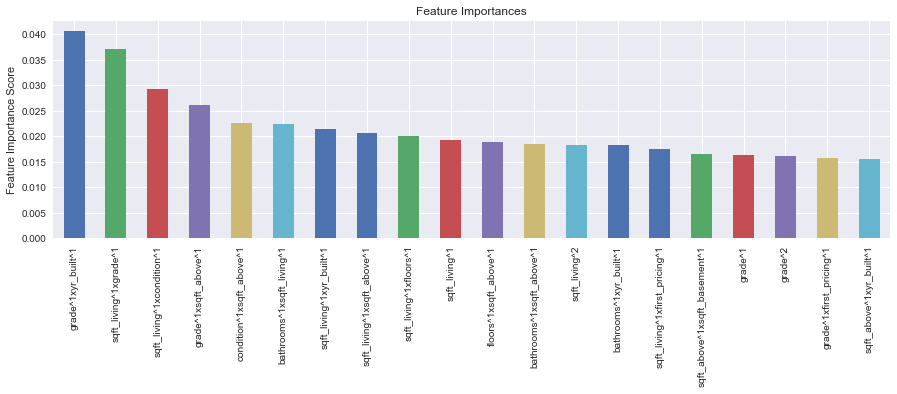

In [101]:
feat_imp = pd.Series(gb_final.feature_importances_, X_poly.columns\
                             ).sort_values(ascending=False)[:20]
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(15,4))
plt.ylabel('Feature Importance Score')

In [110]:
# Let's compute and print adjusted R^2 (it will be useful for reporting)
print(f"Model's R^2: {r2_score(y_poly_test, y_poly_pred)}\n\
Model's R^2 adj: \
{1 - (1-r2_score(y_poly_test, y_poly_pred))*(len(y_poly_test)-1)/(len(y_poly_test)\
                                                                        -X_poly_test.shape[1]-1)}")

Model's R^2: 0.7429379441816478
Model's R^2 adj: 0.7371476006945412


* ## End notes and future directions

### Results

* Out of three out-of-the-box regressors tried at the early modeling stage gradient boosting gave the best results
* Adding polynomial and interaction terms helped all the regressors and gradient boosting remained the leader
* Further cross-validated hyperparameter tuning of gbr resulted in an increase of $R^2$ value from ``.72`` to ``.726`` 
* The model trained on the whole training set and validated on the test set resulted in $R^2 = 0.742$ and $R^2_{adj} = 0.737$
* Among the most important features were various combinations of ``sqft_living``, ``grade``, ``yr_built``, ``condition``, ``sqft_above`` and ``bathrooms``

### Future directions

I see four dimensions on which predictions could be improved:
* more training examples
* feature engineering
* dataset augmentation
* algorithm selection

#### More training examples

* The learning curve generated above shows that the model could do better if we had more training examples. The test score seems to still increase and did not reach the plateau.

#### Feature engineering

* Based on the description provided I was not sure if ``sqft_living`` is *total square feet living space* (already contains ``sqft_above``) or not. If not they could be added to create a new variable ``total_sqft_living``. Such a variable could be informative to the algorithm.
* Accordinng to some materials found on the internet ``grade`` should be treated as a categorical variable (e.g. https://www.crowdstreet.com/grade-real-estate-understanding-class-a-b-c/). Nevertheless ``grade`` variable in the provided dataset takes values $\{1;13\}$, which is inconsistent with the information about categorical approach to *grade* found on the internet (most of the materials found contain information about three to four classes). I decided to treat it as a numerical variable.

#### Dataset augmentation

* I belive that information about geographic location could help in building more accurate predictions in the future. The same house in Los Angeles would be a way more expensive than in Lima. The same flat on Hoża would cost more than on Gocław.
* There are at least three ways of using location information I could think of:
    * raw location data (latitude and longitude)
    * finding some point (e.g. a point in the the city center), computing a distance from this point to every property (using some distance metric - euclidean, manhattan or maybe Google Maps distance) and using it as a predictor
    * using clustering algorithm to build a price clusters map and using it as a categorical variable (another numerical predictor could also be created: a distance from a cluster's center)
    
#### Algorithm selection
* Another possible way of using location data would be to build an end-to-end neural network model.